# <u> Bounding Box Regressor</u>

## [1] Get details of the instance.

In [ ]:
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

* If you don't get enough RAM (or) get an error, then reset the runtime.

In [ ]:
# Link the Google drive to use the dataset
#from google.colab import drive
#drive.mount('/content/drive')

<u><b>Note:</b></u>

* If you try to run this on your system or any other place like google colaboratory, then please specify proper paths.

## [2] Data preprocessing

In [2]:
# Importing necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential, Model
from keras.layers import Input,Dense,  BatchNormalization, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D , Conv2D
from keras import losses
from matplotlib.patches import Rectangle
from keras.callbacks import EarlyStopping
import os
import random
import keras.backend as K
from tqdm import tqdm
import pickle


/home/appliedai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
## Backend Framework Used
print(K.name_scope)

<class 'tensorflow.python.framework.ops.name_scope'>


In [4]:
current_path = !pwd
# Set the train_dir path properly
train_dir = os.path.join('data','train')
train_img_dir = os.path.join(train_dir,'images')
train_csv = os.path.join(train_dir,'training.csv')
train = pd.read_csv(train_csv)

# get a sample
size = 1000
train = train.iloc[random.sample(range(train.shape[0]),size)].copy()


tr_size = int(train.shape[0]*0.6)
cv_size = int(train.shape[0]*0.2)
te_size = int(train.shape[0]*0.2)

tr_indices = range(tr_size)
cv_indices = range(tr_size,tr_size+cv_size)
te_indices = range(tr_size+cv_size,tr_size+cv_size+te_size)

test = train.iloc[cv_indices].copy()
cv = train.iloc[te_indices].copy()
train = train.iloc[tr_indices].copy()

cv_dir = os.path.join('data','train')
cv_img_dir = os.path.join(cv_dir,'images')

test_dir = os.path.join('data','train')
test_img_dir = os.path.join(test_dir,'images')

In [5]:
cv.shape

(200, 5)

In [6]:
#getting random image from dataset
rows = train.shape[0]
temp = train.iloc[random.randint(0,rows-1)] 
img = mpimg.imread(os.path.join(train_img_dir,temp['image_name']))
img_shape  = img.shape
print("The shape of image is:"+str(img_shape))
print("The maximum and minimum value of each cell in an image is "+str(img.max())+" "+str(img.min()))

The shape of image is:(480, 640, 3)
The maximum and minimum value of each cell in an image is 1.0 0.0


* *Images are in channel-last format.*
* *Images are already normalized.*

In [7]:
# Convert all the train images to numpy array.
images_tr = list()
for img_name in tqdm(train['image_name']):
    images_tr.append(mpimg.imread(os.path.join(train_img_dir,img_name)))
images_tr = np.array(images_tr)

100%|██████████| 600/600 [00:16<00:00, 37.42it/s]


In [8]:
# Convert all the test images to numpy array.
images_cv = list()
for img_name in tqdm(cv['image_name']):
    images_cv.append(mpimg.imread(os.path.join(cv_img_dir,img_name)))
images_cv = np.array(images_cv)

100%|██████████| 200/200 [00:04<00:00, 41.53it/s]


In [ ]:
img_shape = (480,640,3)

## [3] Defining CNN architecture.

In [9]:
learning_rate = 0.01
main_input = Input(shape=img_shape, name='main_input')
c1  = Conv2D(32, (7, 7), activation='relu')(main_input)
m1  = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(c1)
c2  = Conv2D(32, (9, 9), activation='relu')(m1)
m2  = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(c2)
dr1 = Dropout(0.25)(m2)
b1  =  BatchNormalization()(dr1)
fl  = Flatten()(b1)
d1  = Dense(16, activation='relu')(fl)
d2  = Dense(32, activation='relu')(d1)
o1  = Dense(output_dim=1, activation='relu',name = "output-1")(d2)
o2  = Dense(output_dim=1, activation='relu',name = "output-2")(d2)
o3  = Dense(output_dim=1, activation='relu',name = "output-3")(d2)
o4  = Dense(output_dim=1, activation='relu',name = "output-4")(d2)

model = Model(inputs=[main_input,], outputs=[o1,o2,o3,o4])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 474, 634, 32) 4736        main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 237, 317, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 229, 309, 32) 82976       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

/home/appliedai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", name="output-1", units=1)`
  if sys.path[0] == '':
/home/appliedai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", name="output-2", units=1)`
  del sys.path[0]
/home/appliedai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", name="output-3", units=1)`
  
/home/appliedai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", name="output-4", units=1)`
  from ipykernel import kernelapp as app


In [15]:
def batch_training(train,cv,callback,epochs=3,step_save=1,batch_size=32,optimizer='Adam',folder_name="model"):
    model.compile(optimizer='Adam', loss=losses.mean_absolute_error)
    !mkdir models
    !mkdir models/$folder_name
    
    #required
    x = list()
    vy= list()
    ty = list()
    fig,ax = plt.subplots(1,1)
    for _ in range(epochs):
        print("*"*10+"EPOCH_"+str(_+1)+"*"*10)
        history = model.fit({'main_input': train['images']},
              {'output-1': train['x1'], 'output-2': train['x2'],'output-3': train['y1'],'output-4': train['y2']},
              epochs=1, batch_size=batch_size,validation_data = (cv['images'],[cv['x1'],cv['x2'],cv['y1'],cv['y2']]),
              callbacks = callback,verbose = 0)
        
        ax.set_xlabel('epoch') ; ax.set_ylabel('Mean Absolute Loss')
        # list of epoch numbers
        print("Train Loss:"+str(history.history['loss'][0]))
        print("Validation Loss:"+str(history.history['val_loss'][0]))
        x.append(_+1)
        vy.extend( history.history['val_loss'])
        ty.extend( history.history['loss'])
        #plt_dynamic(x, vy, ty, ax,fig)
        ax.plot(x, vy, 'b', label="Validation Loss")
        ax.plot(x, ty, 'r', label="Train Loss")
        plt.grid()
        fig.canvas.draw()
        
        
        if _ % step_save==0:
            model.save("models/"+folder_name+"/"+str(_)+".h5")
            model.save_weights("models/"+folder_name+"/"+str(_)+".w5")
    pass

**********EPOCH_1**********
Train Loss:257.91046447753905
Validation Loss:700.0189135742188
**********EPOCH_2**********
Train Loss:181.7120802815755
Validation Loss:341.96022338867186
**********EPOCH_3**********
Train Loss:170.22700073242189
Validation Loss:328.5694091796875
**********EPOCH_4**********
Train Loss:161.07533915201822
Validation Loss:273.0142504882813
**********EPOCH_5**********
Train Loss:156.97279947916667
Validation Loss:370.40511596679687


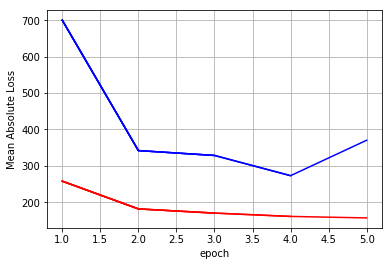

In [16]:
input_tr={'images':images_tr,'x1':train['x1'],'x2':train['x2'],'y1':train['y1'],'y2':train['y2']}
input_cv={'images':images_cv,'x1':cv['x1'],'x2':cv['x2'],'y1':cv['y1'],'y2':cv['y2']}
callback = [EarlyStopping(monitor='val_loss', patience=15, verbose=0),]

model_folder_name = 'sample_model' #Change this every time to save your models in different folders.
batch_training(input_tr,input_cv,callback,epochs=5,batch_size=16,folder_name=model_folder_name)

### [4]Loading and Testing

In [22]:
from keras.models import load_model
model_folder_name = 'model1'
best_model = 40
model = load_model("models/"+model_folder_name+"/"+str(best_model)+".h5")
model.load_weights("models/"+model_folder_name+"/"+str(best_model)+".w5")

In [17]:
# https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


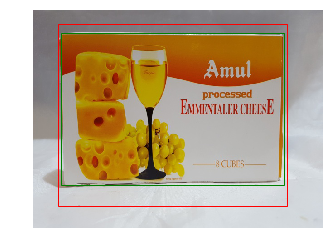

IoU is0.8137054845712709


In [27]:
#getting random image from dataset
rows = train.shape[0]
temp = train.iloc[random.randint(0,rows-1)] 
img = mpimg.imread(os.path.join(train_img_dir,temp['image_name']))

axs = plt.imshow(img)

##drawing bounding box
x1,x2,y1,y2 = temp['x1'],temp['x2'],temp['y1'],temp['y2']
rect = Rectangle((x1,y2),(x2-x1),(y1-y2),linewidth=1,edgecolor='g',facecolor='none')
# Add the patch to the Axes
axs.axes.add_patch(rect)
true=dict()
true['x1'],true['x2'],true['y1'],true['y2']=x1,x2,y1,y2


x1,x2,y1,y2 = model.predict(np.expand_dims(img, axis=0))
rect = Rectangle((x1,y2),(x2-x1),(y1-y2),linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
axs.axes.add_patch(rect)
pred=dict()
pred['x1'],pred['x2'],pred['y1'],pred['y2']=x1,x2,y1,y2 

plt.axis('off')
plt.show()

print("IoU is"+str(get_iou(true,pred)))